In [1]:

# Importing all the necessary libraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\User\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Reading data from SQLite Table

con=sqlite3.connect("database.sqlite")
Data=pd.read_sql_query("select * from Reviews",con)

In [3]:
print("\nNumber of Reviews: ",Data["Text"].count())
print("\nNumber of Users: ",len(Data["UserId"].unique())) # Unique returns 1-D array of unique values of DataFrame.
print("\nNumber of Products: ",len(Data["ProductId"].unique()))
print("\nShape of Data: ",Data.shape)
print("\n",Data.columns)


Number of Reviews:  568454

Number of Users:  256059

Number of Products:  74258

Shape of Data:  (568454, 10)

 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


# 1.0 High Level Description About Data

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454

Number of users: 256,059

Number of products: 74,258

Timespan: Oct 1999 - Oct 2012

Number of Attributes/Columns in data: 10

# 1.1 Attribute Information of the Dataset:

Id - A unique value starts from 1

ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName - Name of user profile 

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review

Text - text of the review

# 2.0 Objective : 
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

In [4]:
# Taking 3 as neutral score. 
# Let's check how many have score value equal to 3 
print(pd.read_sql_query("select score,count(score) as Total_Count from Reviews where score==3",con).head(5))


   Score  Total_Count
0      3        42640


In [5]:
# Since 42,640 Data are having score of 3
# So it has to be removed from Dataset

filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3 ", con) 

In [6]:
# Giving reviews with Score>3 a positive rating (1),and reviews with a score<3 a negative rating (0).

def reviewchange(x):
    if x < 3:
        return 0
    return 1

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(reviewchange) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(2)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


# 3.0 Exploratory Data Analysis 

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


# 3.1 Data Cleaning: Deduplication

(i). It is observed (as shown in the table above) that the reviews data had many duplicate entries. Hence it was  
     necessary to remove duplicates in order to get unbiased results for the analysis of the data.
     
(ii). As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

(iii). ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

(iv). ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

(v).  It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

(vi). The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."


In [9]:
# Removal of Duplicate entries (Deduplication of entries).
# It will find duplicates on the basis of element contained by subset by default it uses all columns. 

final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
print(final.shape)

(364173, 10)


In [10]:
#Checking to see how much % of data still remains

print("% of Data present in Dataset: {:.2f}".format((final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100))

% of Data present in Dataset: 69.26


In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


# Observation :

1. In the above table It can be seen that in two rows given the value of HelpfulnessNumerator is greater than  
   HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions.

2. HelpfulnessNumerator   : No of people given yes
   HelpfulnessDenominator : No of people given yes and no both included.

3. So HelpfulnessNumerator sholud be always less than HelpfulnessDenominator  

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
print("Shape of the DataSet: ",final.shape)

#How many positive and negative reviews are present in our dataset?
print("\n",final['Score'].value_counts())

Shape of the DataSet:  (364171, 10)

 1    307061
0     57110
Name: Score, dtype: int64


# 4.0 Text Preprocessing

   Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags

2. Remove any punctuations or limited set of special characters like , or . or # etc.

3. Check if the word is made up of english letters and is not alpha-numeric

4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5. Convert the word to lowercase

6. Remove Stopwords

7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)


In [14]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text']:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [15]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [16]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    
    #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final_string 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    
    # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f: # we need not to call close() because it will automatically close.
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [17]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [18]:
final.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...


# 5.0 Bag Of Words

In [19]:
count_vect=CountVectorizer()
Bow_counts=count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(Bow_counts))
print("\nthe shape of out text BOW vectorizer ",Bow_counts.get_shape())
print("\nthe number of unique words ", Bow_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>

the shape of out text BOW vectorizer  (364171, 71624)

the number of unique words  71624


In [20]:
Bow_counts.get_shape()

(364171, 71624)

In [21]:
print("DocNo WordPos Count")
#print(Bow_counts[0])

DocNo WordPos Count


# 5.1 Applying TSNE On Bag Of Words

In [23]:
from sklearn.manifold import TSNE
data = Bow_counts[:25000]
y=data.todense()

In [ ]:
model=TSNE(n_components=2,random_state=0)
tsne_data= model.fit_transform(y)

In [49]:
tsne_data.shape

(2500, 2)

In [50]:
label = final['Score'][:2500]

In [51]:
label.shape

(2500,)

In [52]:
data = np.vstack((tsne_data.T,label)).T

In [53]:
data.shape

(2500, 3)

In [54]:
df=pd.DataFrame(data,columns=['X','Y','Label'])
df['Label'].value_counts()

1.0    2075
0.0     425
Name: Label, dtype: int64

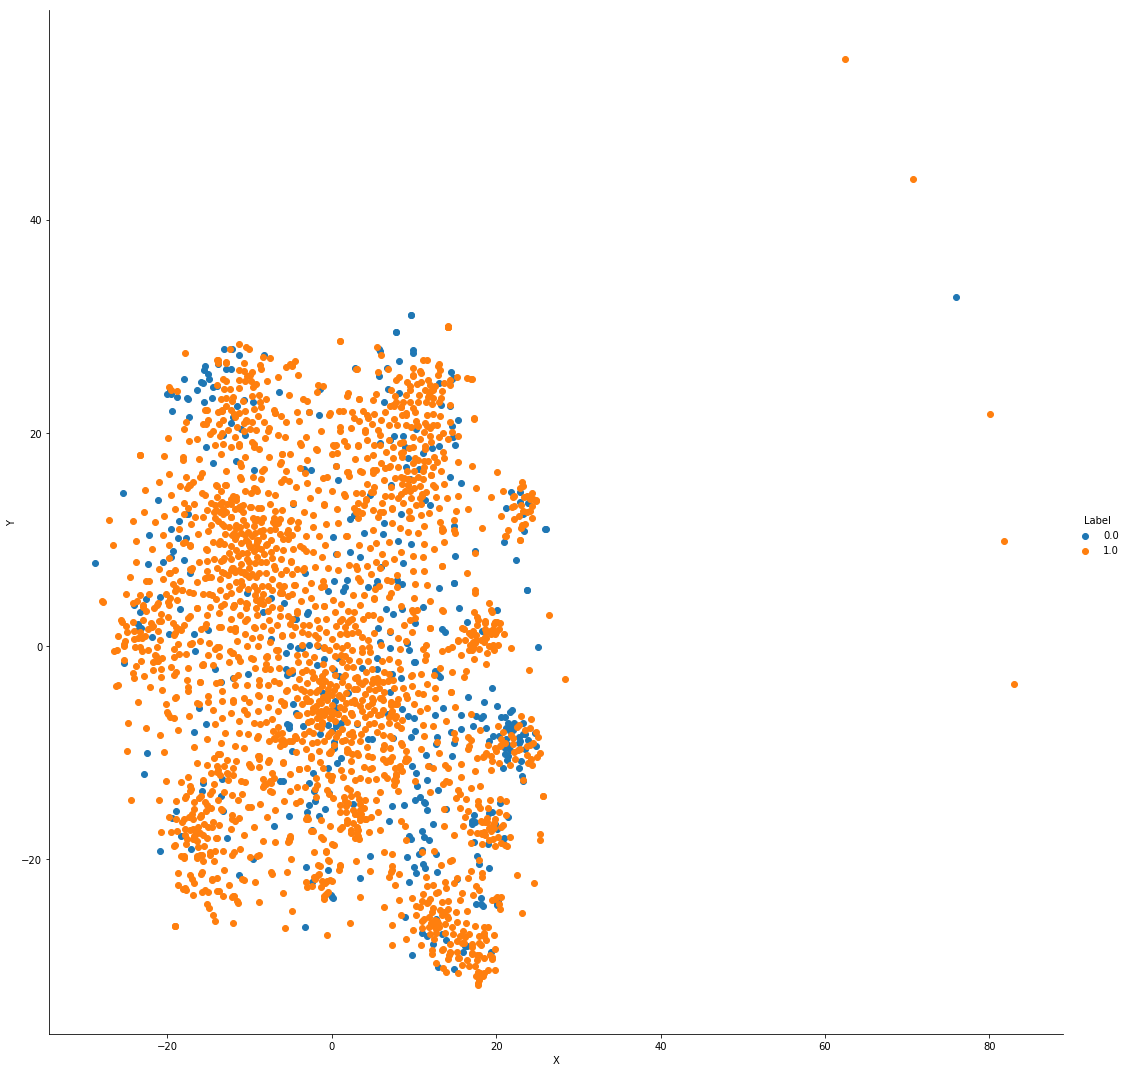

In [55]:
sns.FacetGrid(data=df,hue='Label',height=15).map(plt.scatter,'X','Y').add_legend()
plt.show()

## TF-IDF

In [56]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (364171, 2923725)
the number of unique words including both unigrams and bigrams  2923725


In [58]:
y = final_tf_idf[:500].todense()
y.shape

(500, 2923725)

In [ ]:

from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0)
tsne_data= model.fit_transform(y)

In [69]:
label = final['Score'][5000:5100]
data = np.vstack((tsne_data.T,label)).T
df=pd.DataFrame(data,columns=['X','Y','Label'])
df['Label'].value_counts()

1.0    80
0.0    20
Name: Label, dtype: int64

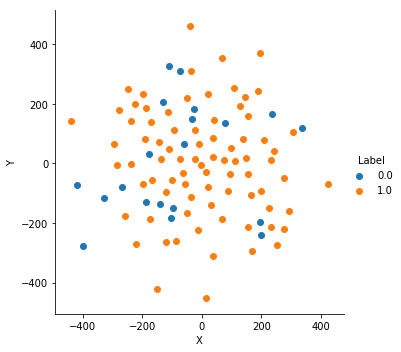

In [70]:
sns.FacetGrid(data=df,hue='Label',height=5).map(plt.scatter,'X','Y').add_legend()
plt.show()